### Install the FireDrone API Client SDK

We have provided an easy to install SDK that you can use to control your drone within the simulation environment. Run the following command to pip install the SDK.

In [2]:
!pip install --index-url https://test.pypi.org/simple/ fire-drone-sdk -U

Looking in indexes: https://test.pypi.org/simple/
Requirement already up-to-date: fire-drone-sdk in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (0.2.25)


### Import dependencies
Once you have the SDK installed, you need to import the FireDrone Client and related modules.

In [3]:
import firedrone.client as fdc
from firedrone.client.errors import FireDroneClientHttpError
import os

### Provide your API key 

This is the key you get through the registration process (described in the `Registration.ipynb` notebook).

In [4]:
# Use any convenient way to get your FireDrone API Key.
# You should use the user token you received when registering to the contest.
api_key = ''...'

### Create your client workspace

In [5]:
# Create a new client workspace.
# -------------------------------------------------------------------------------------------
workspace = fdc.Workspace(api_key)

### Get a list of available scenes you can use for direct runs
Your drone will scan a large scene, and is provided images within its field of view for that larger scene. To begin, you need to choose a scene.

In [6]:
# Get a list of available scenes.
# -------------------------------------------------------------------------------------------
scenes = workspace.get_scenes()
print(scenes)

Sending GET request to https://api.firedrone.ai/v1/scenes/all
[{'id': 20, 'name': 'No-fire scene', 'description': 'This is a really challenging scene.', 'isDisabled': False}, {'id': 21, 'name': 'Notre-Dame in flames', 'description': 'This is a really challenging scene.', 'isDisabled': False}]


### Start a direct run

Attempt to start a direct run. When you want to fly a virtual drone around the scene, you need to start a direct run. This will collect telemetry about your run in the back end as well, that we will use later during the competition rounds.

Notice the try/catch that is needed to cover the case in which you already have an active run which you did not end properly.
Try to run the cell below two times and notice the error message you get the second time instructing you to end the active run.

In [9]:
# Start a new direct run
# Use exception handling just in case you have not terminated a previous run.
# If that is the case, the error message will instruct you to run the END operation on the active run to end it.
# -------------------------------------------------------------------------------------------

try:
    start_result = workspace.directrun_start(21)
    print(start_result)
except FireDroneClientHttpError as e:
    display(e)

Sending POST request to https://api.firedrone.ai/v1/directruns/start?sceneid=21
{'uniqueId': '267b1681-dd9a-4d63-a15c-a8d638100042'}


Save your run identifier for later, you will need it for any action you want to execute as part of the run.

In [10]:
# Save the run id for later
# -------------------------------------------------------------------------------------------
run_id = start_result['uniqueId']
run_id

'267b1681-dd9a-4d63-a15c-a8d638100042'

### Request the current image from the drone's field of view
You can request a frame from the drone showing what it currently "sees" in its field of view (FoV).

In [11]:
frame = workspace.get_drone_fov_image(run_id)
with open('./frame.png', 'wb') as f:
   f.write(frame)

Sending GET request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/dronefieldofviewimage


Now take a look at the image received from the drone's framebuffer.

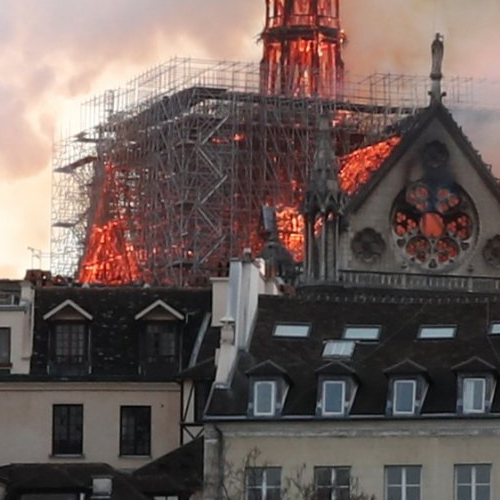

In [12]:
from IPython.display import Image
Image(filename='frame.png') 

### Move the drone
You can move the drone up, down, left and right and then re-request the frame from the FoV.

If you get a response of `{'success':True}` then the drone moved. If you get `False` back, then the drone was already at the edges of the scene and did not move.

Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/movedown
{'success': False}
Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/moveup
{'success': True}
Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/moveup
{'success': True}
Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/moveleft
{'success': True}
Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/moveleft
{'success': True}
Sending GET request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/dronefieldofviewimage


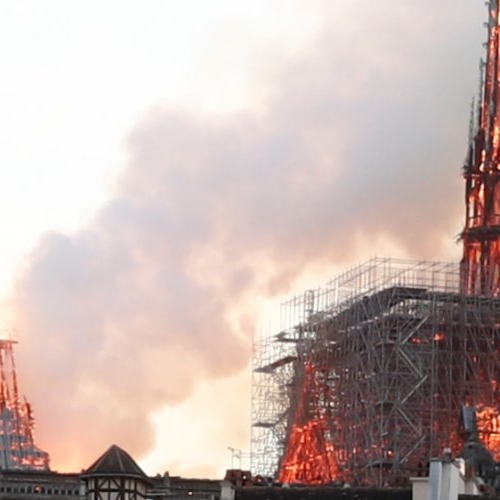

In [13]:
# Try moving the drone down - notice the failure, the drone is at ground level initially
# -------------------------------------------------------------------------------------------
move_result = workspace.directrun_move_down(run_id)
print(move_result)

# Try moving the drone 
# -------------------------------------------------------------------------------------------
move_result = workspace.directrun_move_up(run_id)
print(move_result)
move_result = workspace.directrun_move_up(run_id)
print(move_result)
move_result = workspace.directrun_move_left(run_id)
print(move_result)
move_result = workspace.directrun_move_left(run_id)
print(move_result)

# Get the current drone field of view image
# -------------------------------------------------------------------------------------------

frame = workspace.get_drone_fov_image(run_id)
with open('./frame.png', 'wb') as f:
   f.write(frame)

from IPython.display import Image
Image(filename='frame.png') 

# You're good to go!

From here, you are ready to begin crafting your solution. How will you process the images for fire? How will you navigate the drone across the scene? How will you operationalize (e.g., manage model version, deploy updates to code and/or model)?

**This is where your imagination and skills are the only limits!**

We're giving you the images, it's totally up to you how you approach the detection of those nasty fires :)

### Simple and complex scoring of an image

The following shows how you could call the scoring function within the context of a direct run. 

The previous frame clearly showed fire, so you would call tell the system fire was detected by passing `True` to the `directrun_score()` method (alternately, pass `False` to indicate no fire detected). This is simple scoring.

Alternately, instead of supplying True or False, you can supply a bitmask that indicates which pixels indicate fire in the frame as a flattened array instead of 2D matrix. 

For example, if the frame you received from the drone is 20 pixels by 30 pixels you would have `20x30=600` entries in the array, one entry for every pixel in the frame. Each entry has a value of either a 0 (no fire) or a 1 (fire detected). This is complex scoring.

In either case, you will get back `{'scoreRecorded': True}` that confirms your scoring was successfully recorded in the system.

In [14]:
# Score the drone field of view image
# -------------------------------------------------------------------------------------------
score_result = workspace.directrun_score(run_id, True)
print(score_result)

# Score the drone field of view image pixels
# -------------------------------------------------------------------------------------------
pixels_on_fire = [1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1]
score_result = workspace.directrun_score_pixels(run_id, pixels_on_fire)
print(score_result)

Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/score?firedetected=True
{'scoreRecorded': True}
Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/scorepixels
{'scoreRecorded': True}


### End your run

All runs must come to an end. If you don't end your run, the virtual environment will not permit you to start a new one.

In [16]:
# End the run
workspace.directrun_end(run_id)

Sending POST request to https://api.firedrone.ai/v1/directruns/267b1681-dd9a-4d63-a15c-a8d638100042/end


### Get your history

We're recording all your actions so you can analyze them later. You can get a list of all your direct runs and then, for each one of them get its full history.

In [17]:
# Get a historical list of all your runs

run_history = workspace.directrun_get_history()
print(run_history)

Sending GET request to https://api.firedrone.ai/v1/directruns/history
{'directRuns': ['2019_06_09_14_10_37_bce5399c-ac2d-49f7-98b6-907c1e538c69', '2019_06_09_14_24_59_f81e7022-1a44-4a44-830b-5e7e7b655ea8', '2019_06_09_14_32_09_8a933441-7f21-462b-9723-f08f7e1b9a84', '2019_06_09_14_58_02_afe5b835-0abc-49f3-9409-08f74e447cd6', '2019_06_09_15_26_18_708964c5-0648-451a-91ee-9465c629a0e9', '2019_06_09_15_32_01_96a4c51d-7301-46bb-80e5-146a47e8e895', '2019_06_09_15_48_35_cc07491a-e0f7-4dfe-b6e8-0e6ae8876caa', '2019_06_09_19_51_02_d5403f00-19c6-4edd-91cc-1e50461bd629', '2019_06_23_03_33_49_f4965684-0429-486b-8798-992f8d3e31fd', '2019_06_25_16_21_23_54d41f34-4fd7-4312-9c98-04837451957a', '2019_06_25_16_22_03_f10222b1-2432-4042-90f6-6181126feb89', '2019_06_25_20_01_13_267b1681-dd9a-4d63-a15c-a8d638100042']}


Get the full history of a specified direct run.

In [18]:
run_history_entry = workspace.directrun_get_history_entry('2019_06_09_15_26_18_708964c5-0648-451a-91ee-9465c629a0e9')
print(run_history_entry)

Sending GET request to https://api.firedrone.ai/v1/directruns/history/2019_06_09_15_26_18_708964c5-0648-451a-91ee-9465c629a0e9
{'content': '{\r\n  "Events": [\r\n    {\r\n      "TimeOfOccurrence": "2019-06-09T15:26:18.6190577Z",\r\n      "EventType": 1,\r\n      "EventDetails": null\r\n    },\r\n    {\r\n      "TimeOfOccurrence": "2019-06-09T15:26:21.3729526Z",\r\n      "EventType": 7,\r\n      "EventDetails": "abac890e-adad-4126-8f6c-098e7c1b95ce"\r\n    },\r\n    {\r\n      "TimeOfOccurrence": "2019-06-09T15:26:32.5271195Z",\r\n      "EventType": 4,\r\n      "EventDetails": false\r\n    },\r\n    {\r\n      "TimeOfOccurrence": "2019-06-09T15:26:32.7867085Z",\r\n      "EventType": 3,\r\n      "EventDetails": true\r\n    },\r\n    {\r\n      "TimeOfOccurrence": "2019-06-09T15:26:33.7427393Z",\r\n      "EventType": 3,\r\n      "EventDetails": true\r\n    },\r\n    {\r\n      "TimeOfOccurrence": "2019-06-09T15:26:33.9918012Z",\r\n      "EventType": 5,\r\n      "EventDetails": true\r\n   

Here is the original definition of the event types that are recorded in the log:
```c#
    public enum DirectRunLogEventType
    {
        DirectRunStart = 1,
        DirectRunEnd = 2,

        DroneMoveUp = 3,
        DroneMoveDown = 4,
        DroneMoveLeft = 5,
        DroneMoveRight = 6,

        DroneGetFieldOfViewImage = 7,

        ScoreImage = 8,
        ScoreImagePixels = 9
    }
```

In the case of event type 7, the EventDetails field contains a unique identifier of the image that was returned.

In the case of event type 8, the EventDetails field contains the boolean value submited when scoring.

In the case of event type 9, the EventDetails field contains the string representation of the 0/1 bits submitted when scoring.

In [19]:
import json
entry_data = json.loads(run_history_entry['content'])
entry_data

{'Events': [{'TimeOfOccurrence': '2019-06-09T15:26:18.6190577Z',
   'EventType': 1,
   'EventDetails': None},
  {'TimeOfOccurrence': '2019-06-09T15:26:21.3729526Z',
   'EventType': 7,
   'EventDetails': 'abac890e-adad-4126-8f6c-098e7c1b95ce'},
  {'TimeOfOccurrence': '2019-06-09T15:26:32.5271195Z',
   'EventType': 4,
   'EventDetails': False},
  {'TimeOfOccurrence': '2019-06-09T15:26:32.7867085Z',
   'EventType': 3,
   'EventDetails': True},
  {'TimeOfOccurrence': '2019-06-09T15:26:33.7427393Z',
   'EventType': 3,
   'EventDetails': True},
  {'TimeOfOccurrence': '2019-06-09T15:26:33.9918012Z',
   'EventType': 5,
   'EventDetails': True},
  {'TimeOfOccurrence': '2019-06-09T15:26:34.2362586Z',
   'EventType': 5,
   'EventDetails': True},
  {'TimeOfOccurrence': '2019-06-09T15:26:34.54175Z',
   'EventType': 7,
   'EventDetails': '99f7c3bf-160c-413a-b39f-ad93080a6a57'},
  {'TimeOfOccurrence': '2019-06-09T15:26:50.0198117Z',
   'EventType': 8,
   'EventDetails': True},
  {'TimeOfOccurrence': 